In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/github/data-science/new_project

/content/drive/MyDrive/github/data-science/new_project


In [3]:
%ls

 Balanced_I_hotel_dataset_final.ipynb     LSTM_stop_final_lstm_ablation.ipynb
 Balanced_II_hotel_dataset_final.ipynb    optuna_test/
 booking_time_final_original/             output/
 Business_hotel_dataset_final.ipynb       output_other_dataset/
 clustered_test.pkl                       Preprocess_data_dunnhumby.ipynb
 copy_optuna_test/                        Preprocess_data_full_hotel_dataset_final.ipynb
 data_analysis/                           price_tft/
 Leisure_hotel_dataset_final.ipynb        RandomForestRegressor_final_dunnhumby.ipynb
 lightning_logs/                          RandomForestRegressor_final.ipynb
 LSTM_final_dunnhumby_FINAL.ipynb        'Readme file.gdoc'
 LSTM_next_final_ablation.ipynb           TFT_creation_to_creation_final.ipynb
 LSTM_next_final.ipynb                    tft.pkl
 LSTM_next_final_no_lstm_ablation.ipynb   TFT_target_price_final.ipynb
 LSTM_stop_final_ablation.ipynb           Trained_models/
 LSTM_stop_final.ipynb                    Transformer_enc

imported libraries

In [4]:
!pip install pytorch_forecasting
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_exten

In [5]:

import os
import pandas as pd
from datetime import date, timedelta, datetime
import numpy as np
import lightning.pytorch as pl



import math
from sklearn.model_selection import TimeSeriesSplit


import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
import plotly.graph_objects as go

import matplotlib.pyplot as plt


To ignore warnings:

In [6]:

import warnings
warnings.filterwarnings('ignore')

In [7]:
df_all_hotels_remv = pd.read_feather('output/10_selected_guest_data/df_all_hotels_remv_updated_withminus1000_dif_clus')

In [8]:
df_all_hotels_remv = df_all_hotels_remv[df_all_hotels_remv["vacation_type"] == "business"]

In [9]:
grouped_amount = df_all_hotels_remv.groupby("guest_id").agg({"amount_times_visited" : "mean"})

In [10]:
grouped_amount["amount_times_visited"].describe()

count    1300.000000
mean        3.489231
std         2.657632
min         2.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        41.000000
Name: amount_times_visited, dtype: float64

In [11]:
df_all_hotels_remv = df_all_hotels_remv.drop(["level_0", "index", "state", "birthday", "reservation_id", "arrival", "departure", "booking_channel", "hotel_name"], axis = 1)
df_all_hotels_remv = df_all_hotels_remv.set_index(["guest_id", "time_index"])

In [12]:
dates = pd.date_range(start=df_all_hotels_remv["creation_date"].dt.date.min(), end= df_all_hotels_remv["creation_date"].dt.date.max())
lst_values = list(range(1, len(dates) + 1))
dict_dates = {dates[i]: lst_values[i] for i in range(len(dates))}

In [13]:
df_all_hotels_remv["time_index_with_creation_date"] = df_all_hotels_remv["creation_date"].dt.date.map(dict_dates)
df_all_hotels_remv = df_all_hotels_remv.drop(["creation_date"], axis = 1)

In [14]:
df_copy = df_all_hotels_remv.copy()

In [15]:
X = df_copy.drop(["creation_to_new_creation", "group_type", "vacation_type"], axis = 1)
y = df_copy["creation_to_new_creation"]

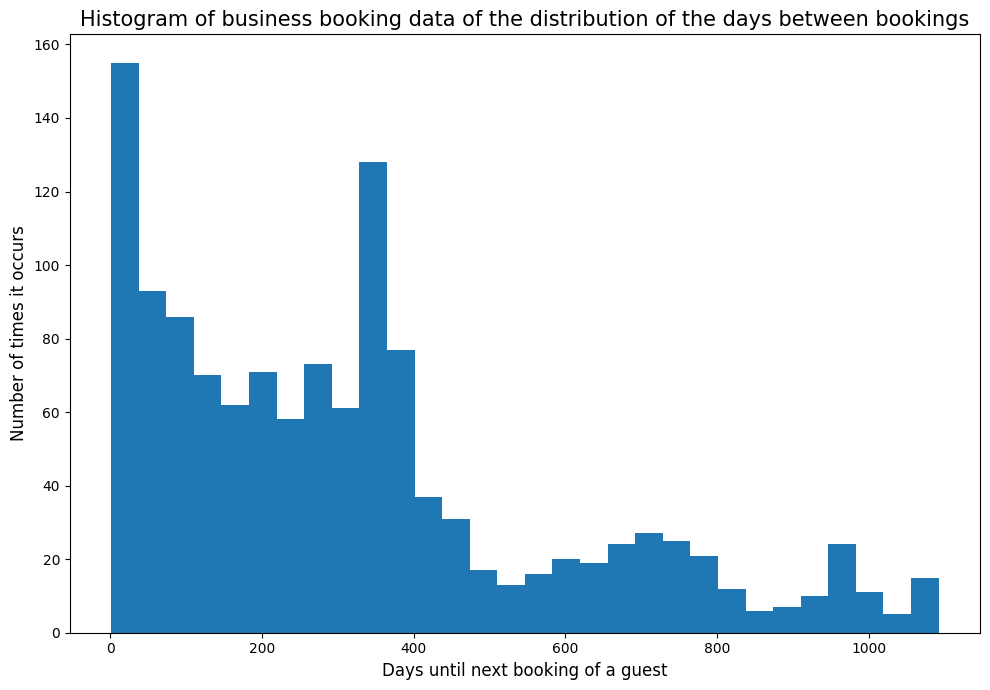

In [16]:
y_without_1000 = y[y > 0]
fig, axs = plt.subplots(1, 1,
                        figsize =(10, 7),
                        tight_layout = True)

axs.hist(y_without_1000, bins = 30)
plt.title("Histogram of business booking data of the distribution of the days between bookings", size = 15)
plt.xlabel("Days until next booking of a guest", size = 12)
plt.ylabel("Number of times it occurs", size = 12)
# Show plot
plt.show()

In [17]:
y.to_csv('output/10_selected_guest_data/y_business_data')

In [18]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(scaled, index = X.index, columns = [X.columns])
df_scaled.to_csv('output/10_selected_guest_data/df_business_data')

In [19]:
scaler = RobustScaler()
scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(scaled, index = X.index, columns = [X.columns])
df_scaled.to_csv('output/10_selected_guest_data/df_business_data_robustscaler')

In [20]:
scaler = StandardScaler()
scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(scaled, index = X.index, columns = [X.columns])
df_scaled.to_csv('output/10_selected_guest_data/df_business_data_standardscaler')

In [21]:
df_scaled

nights  infants      kids    adults   lodging  \
guest_id time_index                                                    
100033   4           2.471021 -0.12941 -0.265525 -0.239342  0.686358   
         5           2.471021 -0.12941 -0.265525 -0.239342  0.986241   
100380   1           0.000573 -0.12941 -0.265525 -0.417093 -0.433829   
         2           0.353494 -0.12941 -0.265525 -0.239342 -0.309169   
100428   1          -0.705269 -0.12941 -0.265525 -0.239342 -0.223016   
...                       ...      ...       ...       ...       ...   
99619    1           0.000573 -0.12941 -0.265525 -0.239342 -0.417493   
99654    2           1.059336 -0.12941 -0.265525 -0.239342 -0.179827   
99679    1          -0.352348 -0.12941 -0.265525 -0.239342 -0.453666   
         2          -0.352348 -0.12941 -0.265525 -0.239342 -0.448998   
99960    2           1.765179 -0.12941  1.422683  0.116158  0.329298   

                       beauty    extras restaurant     price     rooms  ...  \
guest_id time_index                                                     ...   
100033   4          -0.160354  1.270220        0.0  0.824472 -0.265521  ...   
         5          -0.289703  1.311069        0.0  1.082674 -0.265521  ...   
100380   1          -0.289703 -0.318633        0.0 -0.450440 -0.265521  ...   
         2          -0.289703 -0.194256        0.0 -0.319443 -0.265521  ...   
100428   1          -0.289703 -0.211850        0.0 -0.248780 -0.265521  ...   
...                       ...       ...        ...       ...       ...  ...   
99619    1          -0.289703 -0.249825        0.0 -0.423198 -0.265521  ...   
99654    2           0.961456  0.727769        0.0  0.039770 -0.265521  ...   
99679    1          -0.289703 -0.143565        0.0 -0.433894 -0.265521  ...   
         2          -0.289703 -0.084686        0.0 -0.418585 -0.265521  ...   
99960    2          -0.289703 -0.214638        0.0  0.225339  0.031162  ...   

                    holiday_arrival_date vacation_creation_date  \
guest_id time_index                                               
100033   4                     -0.207156               1.837601   
         5                     -0.207156               1.837601   
100380   1                     -0.207156              -0.544188   
         2                     -0.207156              -0.544188   
100428   1                     -0.207156              -0.544188   
...                                  ...                    ...   
99619    1                     -0.207156              -0.544188   
99654    2                     -0.207156              -0.544188   
99679    1                     -0.207156              -0.544188   
         2                     -0.207156              -0.544188   
99960    2                     -0.207156              -0.544188   

                    holiday_creation_date weekday_arrival_date  \
guest_id time_index                                              
100033   4                            0.0             1.242453   
         5                            0.0             1.242453   
100380   1                            0.0             0.721733   
         2                            0.0             1.242453   
100428   1                            0.0             0.721733   
...                                   ...                  ...   
99619    1                            0.0             1.242453   
99654    2                            0.0            -1.361144   
99679    1                            0.0             1.242453   
         2                            0.0             1.242453   
99960    2                            0.0             1.242453   

                    weekday_creation_date weekend_arrival_date  \
guest_id time_index                                              
100033   4                       1.411160             1.235587   
         5                       0.294445             1.235587   
100380   1                       0.852803             1.235587 